In [1]:
%matplotlib inline
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
pd.set_option('display.max_columns', None)
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score


In [13]:
# Charger les fichiers CSV pour l'exploration des participants et des ROIs

train_participants = pd.read_csv(r'C:\Users\chemm\OneDrive\Bureau\cours\MOSEF\Machine Learning\brain_anatomy_schizophrenia_IMSD-GRA-MOSEF_2024\data\train_participants.csv')
test_participants = pd.read_csv(r'C:\Users\chemm\OneDrive\Bureau\cours\MOSEF\Machine Learning\brain_anatomy_schizophrenia_IMSD-GRA-MOSEF_2024\data\test_participants.csv')

train_rois = pd.read_csv(r'C:\Users\chemm\OneDrive\Bureau\cours\MOSEF\Machine Learning\brain_anatomy_schizophrenia_IMSD-GRA-MOSEF_2024\data\train_rois.csv')
test_rois = pd.read_csv(r'C:\Users\chemm\OneDrive\Bureau\cours\MOSEF\Machine Learning\brain_anatomy_schizophrenia_IMSD-GRA-MOSEF_2024\data\test_rois.csv')

In [16]:
print(train_rois.shape)
print(train_participants.shape)

(410, 291)
(410, 11)


In [5]:
train_participants.head().to_csv("train_participants_head.csv",sep=";", index=False)
train_rois.head().to_csv("train_rois_head.csv", sep=";",index=False)

In [37]:
rois_with_diagnosis_fixed = pd.merge(train_participants[['participant_id','diagnosis']], train_rois)
rois_with_diagnosis_fixed.to_csv("rois_with_diagnosis_fixed.csv", sep=";",index=False)

In [32]:
merged_df_fixed_format.shape

(410, 292)

### 1. Colonnes et leur rôle

participant_id : Identifiant unique des participants de l'étude.

session : Phase ou session d'acquisition des données (par exemple, V1 pour la première session).

sex : Genre du participant, codé (0.0 pour féminin, 1.0 pour masculin).

age : Âge des participants au moment de l'étude.

diagnosis : État clinique des participants, classifié en :
schizophrenia : Participant diagnostiqué avec la schizophrénie.
control : Participant sain utilisé comme témoin.

study : Source ou projet d'où proviennent les données (par exemple, SCHIZCONNECT-VIP).

site : Centre d'acquisition des données (par exemple, NU, MRN, ou WUSTL).

TIV (Total Intracranial Volume) : Volume total intracrânien, utilisé comme facteur de normalisation dans l'analyse cérébrale.

CSF_Vol (Cerebrospinal Fluid Volume) : Volume du liquide céphalorachidien.

GM_Vol (Gray Matter Volume) : Volume de la matière grise.

WM_Vol (White Matter Volume) : Volume de la matière blanche.

Structure cérébrale : Exemples incluent :

    l3thVen_GM_Vol, r3thVen_GM_Vol : Volumes de matière grise dans des zones ventriculaires spécifiques (par exemple, ventricule latéral gauche ou droit).

    lSupTemGy_CSF_Vol, rSupTemGy_CSF_Vol : Volumes de fluide céphalorachidien dans le gyrus temporal supérieur gauche ou droit.

    lTemTraGy_CSF_Vol, rTemTraGy_CSF_Vol : Volumes dans le gyrus temporal transverse.

Hémisphère : Les colonnes sont préfixées par l (gauche) ou r (droite), indiquant les mesures dans l'hémisphère cérébral correspondant.
    Types de matière :
    GM (Gray Matter) : Matière grise.
    WM (White Matter) : Matière blanche.
    CSF (Cerebrospinal Fluid) : Liquide céphalorachidien.

### Objectif des données


Classification binaire : Prédire le diagnostic (schizophrenia ou control) en utilisant les variables démographiques (âge, sexe) et les mesures cérébrales.

Analyse exploratoire : Identifier les régions du cerveau ou les caractéristiques les plus discriminantes entre les groupes.

Étude de corrélation : Examiner comment des facteurs comme l'âge ou le sexe influencent les volumes cérébraux et les diagnostics.

 ### EDA

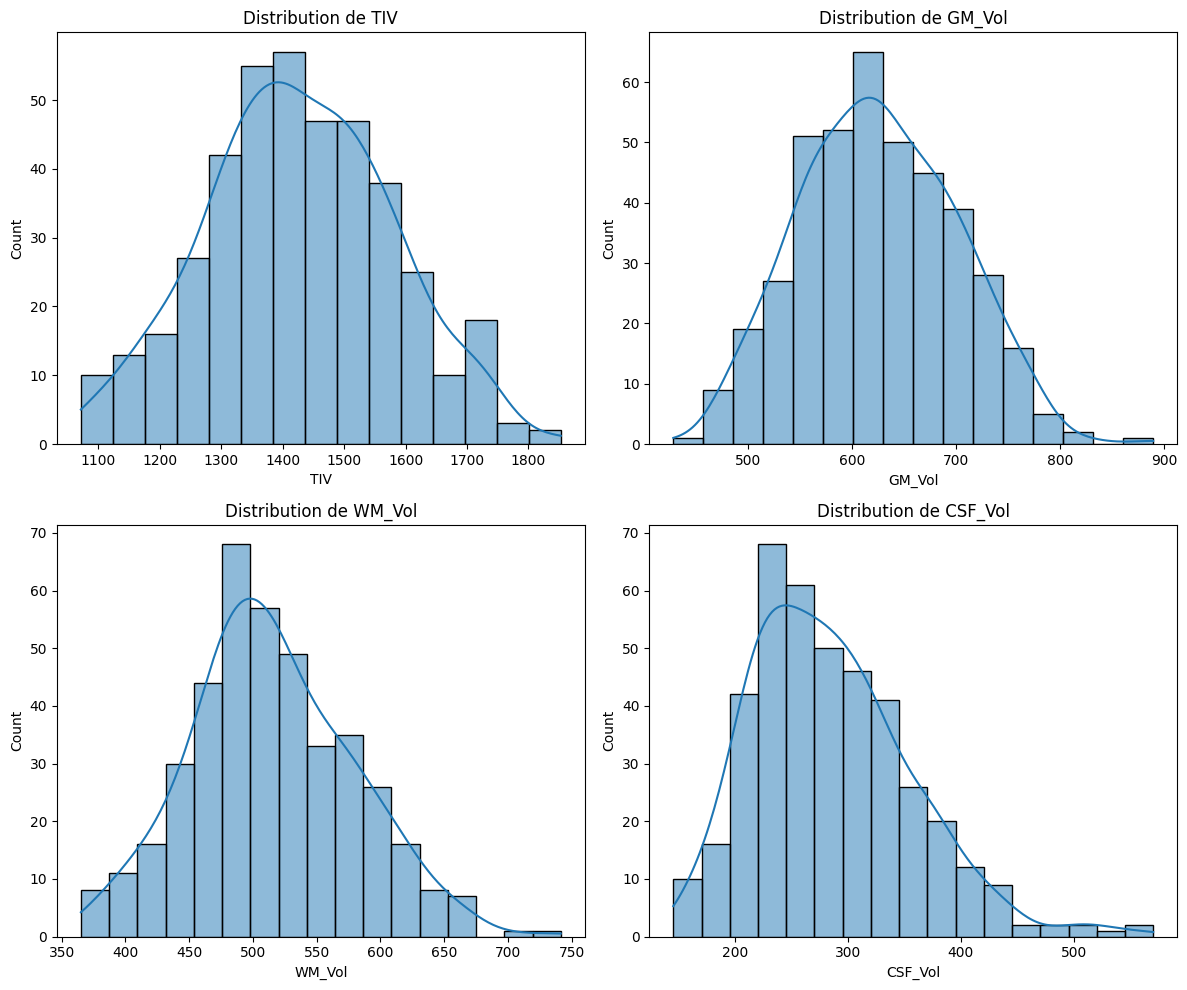

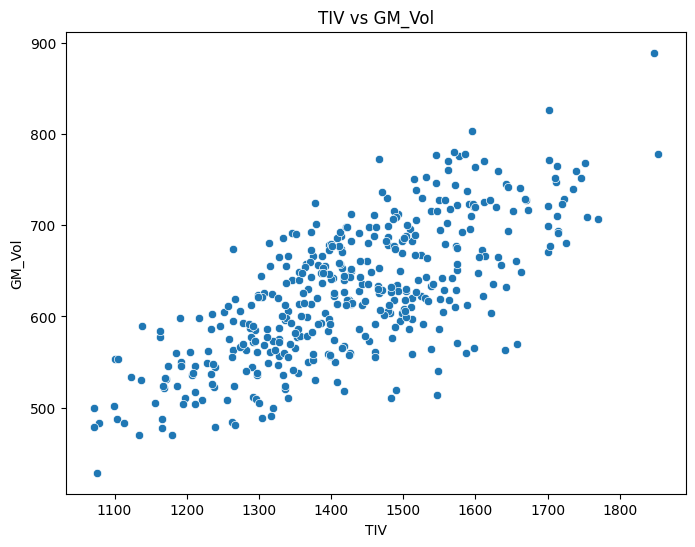

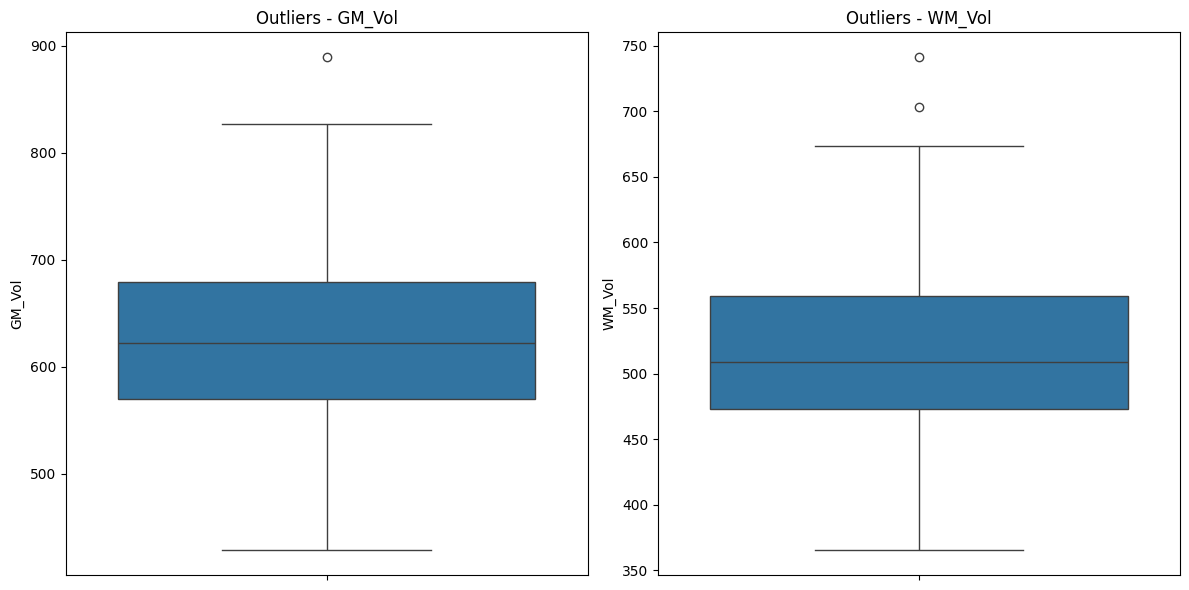

In [47]:
missing_values = rois_with_diagnosis_fixed.isnull().sum()

# Statistiques descriptives
stats = rois_with_diagnosis_fixed.describe()

# Distribution des variables principales
fig, axs = plt.subplots(2, 2, figsize=(12, 10))
sns.histplot(rois_with_diagnosis_fixed['TIV'], kde=True, ax=axs[0, 0]).set_title('Distribution de TIV')
sns.histplot(rois_with_diagnosis_fixed['GM_Vol'], kde=True, ax=axs[0, 1]).set_title('Distribution de GM_Vol')
sns.histplot(rois_with_diagnosis_fixed['WM_Vol'], kde=True, ax=axs[1, 0]).set_title('Distribution de WM_Vol')
sns.histplot(rois_with_diagnosis_fixed['CSF_Vol'], kde=True, ax=axs[1, 1]).set_title('Distribution de CSF_Vol')
plt.tight_layout()

# Corrélation entre TIV et GM_Vol
plt.figure(figsize=(8, 6))
sns.scatterplot(x=rois_with_diagnosis_fixed['TIV'], y=rois_with_diagnosis_fixed['GM_Vol']).set_title('TIV vs GM_Vol')

# Analyse des outliers avec boxplots
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
sns.boxplot(y=rois_with_diagnosis_fixed['GM_Vol'], ax=axs[0]).set_title('Outliers - GM_Vol')
sns.boxplot(y=rois_with_diagnosis_fixed['WM_Vol'], ax=axs[1]).set_title('Outliers - WM_Vol')
plt.tight_layout()

# Sauvegarder les résultats
missing_values.to_csv("missing_values.csv", index=True)
stats.to_csv("stats.csv")


In [ ]:
"""
Corrélation entre TIV et GM_Vol (Graphique TIV vs GM_Vol)
Observation : Il existe une corrélation linéaire claire entre TIV (Volume intracrânien total) et GM_Vol (Volume de matière grise).
Interprétation :
Cela montre que les individus ayant un volume intracrânien total plus élevé tendent à avoir un volume de matière grise plus important.
Cette relation est attendue, car TIV est une mesure globale influençant les volumes régionaux.
Recommandation :
Inclure TIV comme variable de contrôle ou standardiser les volumes cérébraux (par exemple, diviser GM_Vol par TIV) pour les analyses futures.
"""

In [ ]:
""" 
2. Distribution des variables principales (Histogrammes)
Observation :
Les distributions de TIV, GM_Vol, WM_Vol (matière blanche), et CSF_Vol (liquide céphalorachidien) montrent des formes normales ou quasi-normales.
Les histogrammes montrent une population relativement homogène, sans bimodalité apparente.
Interprétation :
Une distribution normale facilite l'application de modèles linéaires pour prédire les volumes.
Les distributions sont cohérentes avec une population saine, mais il faudra comparer avec des patients atteints de schizophrénie pour détecter des anomalies.
Recommandation :
Vérifier la normalité statistiquement (tests de Shapiro-Wilk ou Kolmogorov-Smirnov) pour confirmer les hypothèses de normalité.
"""

In [ ]:
"""
3. Outliers détectés (Boxplots pour GM_Vol et WM_Vol)
Observation :
Quelques outliers sont présents pour GM_Vol et WM_Vol, avec des valeurs extrêmes au-dessus de la plage normale.
Interprétation :
Ces outliers pourraient représenter des anomalies biologiques ou des erreurs de mesure.
Recommandation :
Explorer ces outliers individuellement en croisant les données cliniques.
Décider de les exclure ou de les conserver en fonction de leur pertinence biologique.
"""

In [33]:
# General overview of the dataframe
eda_summary = {
    "Shape": merged_df_fixed_format.shape,
    "Missing Values": merged_df_fixed_format.isnull().sum().sum(),
    "Duplicate Rows": merged_df_fixed_format.duplicated().sum(),
    "Data Types": merged_df_fixed_format.dtypes.value_counts().to_dict()
}

# Basic descriptive statistics
descriptive_stats = merged_df_fixed_format.describe(include='all')

# Displaying the summary and statistics
eda_summary, descriptive_stats.head()


({'Shape': (410, 292),
  'Missing Values': np.int64(0),
  'Duplicate Rows': np.int64(0),
  'Data Types': {dtype('float64'): 288, dtype('O'): 3, dtype('int64'): 1}},
        participant_id diagnosis session    run          TIV     CSF_Vol  \
 count             410       410     410  410.0   410.000000  410.000000   
 unique            410         2       1    NaN          NaN         NaN   
 top            NM1037   control      V1    NaN          NaN         NaN   
 freq                1       222     410    NaN          NaN         NaN   
 mean              NaN       NaN     NaN    1.0  1426.838006  284.925073   
 
           GM_Vol      WM_Vol  l3thVen_GM_Vol  r3thVen_GM_Vol  l4thVen_GM_Vol  \
 count   410.0000  410.000000      410.000000       410.00000      410.000000   
 unique       NaN         NaN             NaN             NaN             NaN   
 top          NaN         NaN             NaN             NaN             NaN   
 freq         NaN         NaN             NaN        

In [38]:
eda_summary_rois = {
    "Shape": rois_with_diagnosis_fixed.shape,
    "Missing Values": rois_with_diagnosis_fixed.isnull().sum().sum(),
    "Duplicate Rows": rois_with_diagnosis_fixed.duplicated().sum(),
    "Data Types": rois_with_diagnosis_fixed.dtypes.value_counts().to_dict()
}

# Basic descriptive statistics for numerical columns
descriptive_stats_rois = rois_with_diagnosis_fixed.describe(include='all')

# Distribution of the 'diagnosis' column
diagnosis_distribution = rois_with_diagnosis_fixed['diagnosis'].value_counts()

# Displaying the summary, statistics, and diagnosis distribution
eda_summary_rois, descriptive_stats_rois.head(), diagnosis_distribution

({'Shape': (410, 292),
  'Missing Values': np.int64(0),
  'Duplicate Rows': np.int64(0),
  'Data Types': {dtype('float64'): 288, dtype('O'): 3, dtype('int64'): 1}},
        participant_id diagnosis session    run          TIV     CSF_Vol  \
 count             410       410     410  410.0   410.000000  410.000000   
 unique            410         2       1    NaN          NaN         NaN   
 top            NM1037   control      V1    NaN          NaN         NaN   
 freq                1       222     410    NaN          NaN         NaN   
 mean              NaN       NaN     NaN    1.0  1426.838006  284.925073   
 
           GM_Vol      WM_Vol  l3thVen_GM_Vol  r3thVen_GM_Vol  l4thVen_GM_Vol  \
 count   410.0000  410.000000      410.000000       410.00000      410.000000   
 unique       NaN         NaN             NaN             NaN             NaN   
 top          NaN         NaN             NaN             NaN             NaN   
 freq         NaN         NaN             NaN        

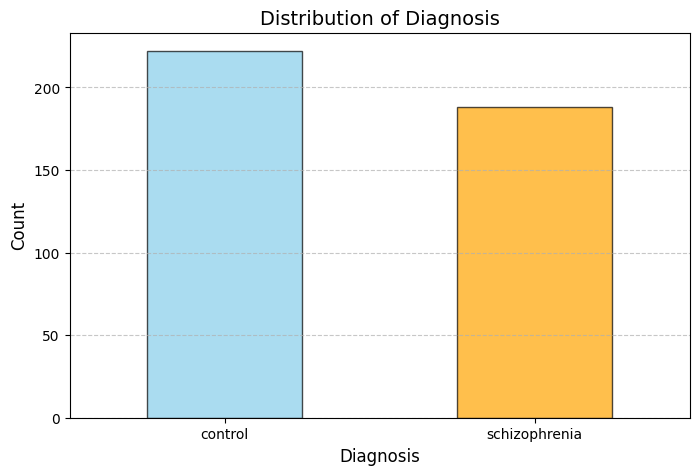

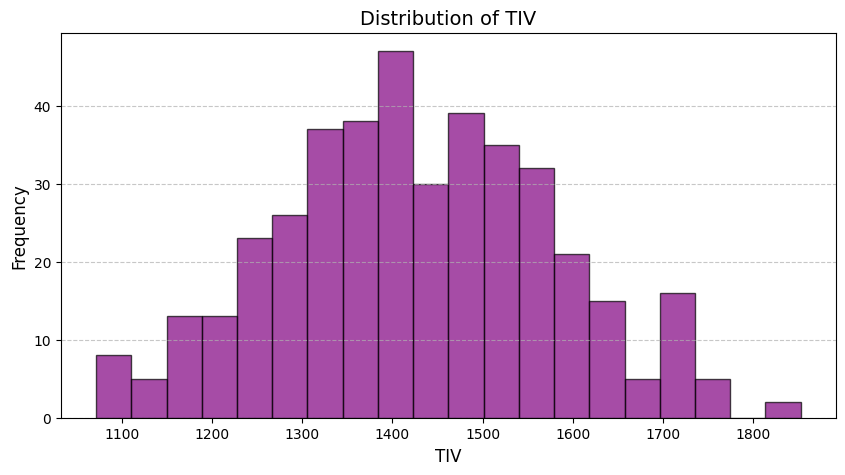

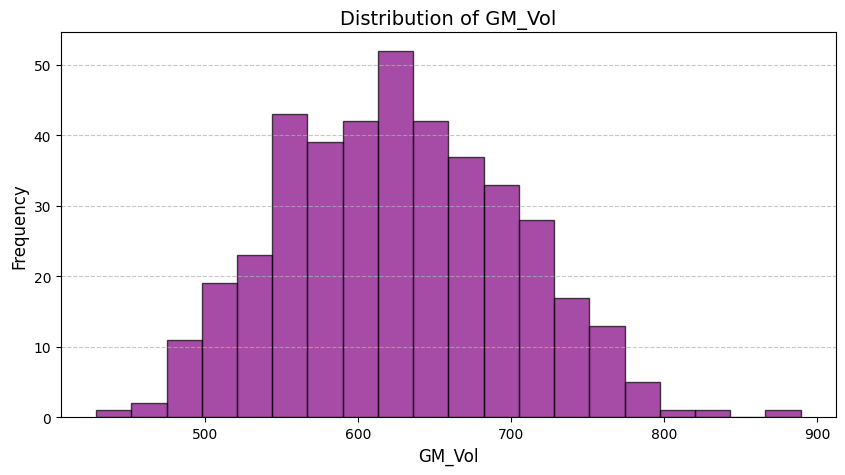

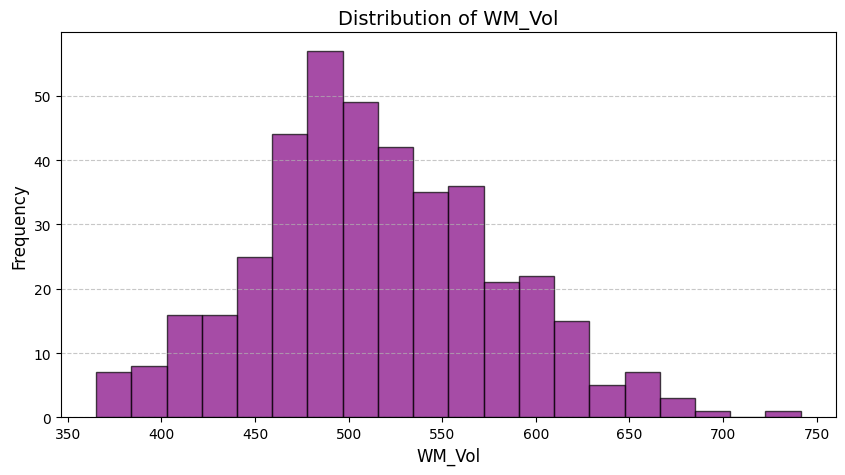

In [39]:
# Visualizing the distribution of diagnosis
diagnosis_counts = rois_with_diagnosis_fixed['diagnosis'].value_counts()
plt.figure(figsize=(8, 5))
diagnosis_counts.plot(kind='bar', color=['skyblue', 'orange'], edgecolor='k', alpha=0.7)
plt.title('Distribution of Diagnosis', fontsize=14)
plt.xlabel('Diagnosis', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Visualizing the distribution of global volumes (TIV, GM_Vol, WM_Vol)
volumes = ['TIV', 'GM_Vol', 'WM_Vol']
for volume in volumes:
    plt.figure(figsize=(10, 5))
    plt.hist(rois_with_diagnosis_fixed[volume], bins=20, edgecolor='k', alpha=0.7, color='purple')
    plt.title(f'Distribution of {volume}', fontsize=14)
    plt.xlabel(volume, fontsize=12)
    plt.ylabel('Frequency', fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()


In [ ]:
"""
Répartition du diagnostic :
Les classes control (222 individus) et schizophrenia (188 individus) sont relativement équilibrées, facilitant l'analyse supervisée.
"""

In [ ]:
""" 
TIV : Distribution légèrement asymétrique, suggérant des variations interindividuelles importantes.
GM_Vol (matière grise) : Distribution normale avec une légère asymétrie vers des valeurs élevées.
WM_Vol (matière blanche) : Distribution plus étroite, indiquant une variabilité réduite.
"""

In [40]:
import seaborn as sns
from scipy.stats import ttest_ind

 ### Comparaison des volumes globaux entre les classes

C:\Users\chemm\AppData\Local\Temp\ipykernel_15240\3793527722.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=rois_with_diagnosis_fixed, x='diagnosis', y=volume, palette='pastel')


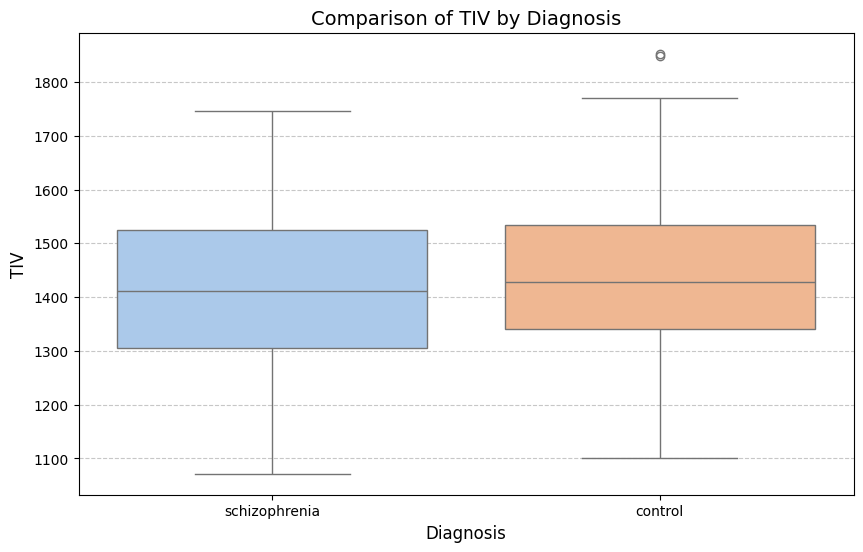

C:\Users\chemm\AppData\Local\Temp\ipykernel_15240\3793527722.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=rois_with_diagnosis_fixed, x='diagnosis', y=volume, palette='pastel')


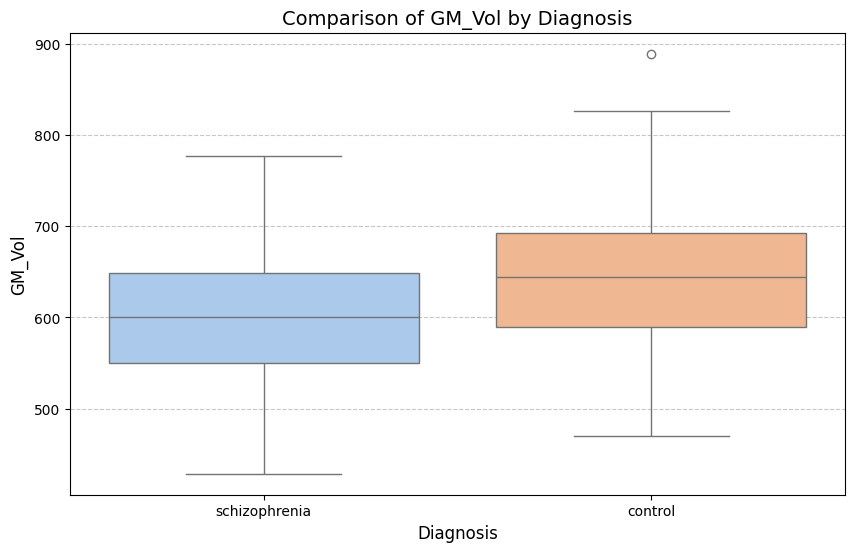

C:\Users\chemm\AppData\Local\Temp\ipykernel_15240\3793527722.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=rois_with_diagnosis_fixed, x='diagnosis', y=volume, palette='pastel')


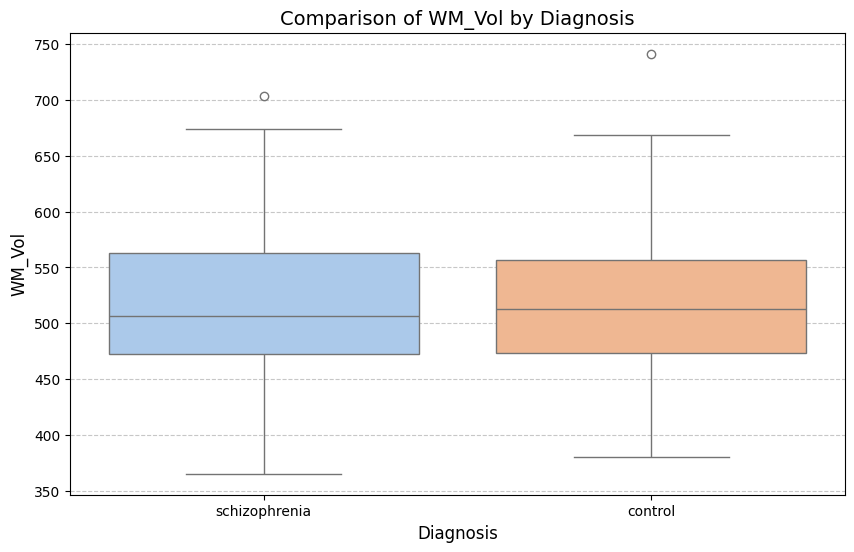

{'TIV': TtestResult(statistic=np.float64(1.4394986257265263), pvalue=np.float64(0.1508146682373223), df=np.float64(388.4387668498033)),
 'GM_Vol': TtestResult(statistic=np.float64(5.845296756823949), pvalue=np.float64(1.0615242092125392e-08), df=np.float64(394.006100682515)),
 'WM_Vol': TtestResult(statistic=np.float64(0.5603587763954196), pvalue=np.float64(0.5755632493827968), df=np.float64(381.9691798230819))}

In [41]:
global_volumes = ['TIV', 'GM_Vol', 'WM_Vol']

import seaborn as sns
from scipy.stats import ttest_ind

# List of global volume variables
global_volumes = ['TIV', 'GM_Vol', 'WM_Vol']

# Boxplots to compare the distributions by diagnosis
for volume in global_volumes:
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=rois_with_diagnosis_fixed, x='diagnosis', y=volume, palette='pastel')
    plt.title(f'Comparison of {volume} by Diagnosis', fontsize=14)
    plt.xlabel('Diagnosis', fontsize=12)
    plt.ylabel(volume, fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

# Perform t-tests to assess statistical significance
ttest_results = {
    volume: ttest_ind(
        rois_with_diagnosis_fixed[rois_with_diagnosis_fixed['diagnosis'] == 'control'][volume],
        rois_with_diagnosis_fixed[rois_with_diagnosis_fixed['diagnosis'] == 'schizophrenia'][volume],
        equal_var=False
    ) for volume in global_volumes
}

ttest_results


In [ ]:
"""
Les boxplots montrent que :
GM_Vol (matière grise) est significativement plus faible dans le groupe schizophrenia.
Les distributions pour TIV et WM_Vol se chevauchent fortement entre les deux classes.
"""

In [ ]:
"""
Tests statistiques :

TIV : Pas de différence significative (p=0.151).
GM_Vol : Différence hautement significative (p<0.001), confirmant une réduction de la matière grise chez les patients schizophrènes.
WM_Vol : Pas de différence significative (p=0.576).
"""

### Analyse des corrélations entre les ROIs

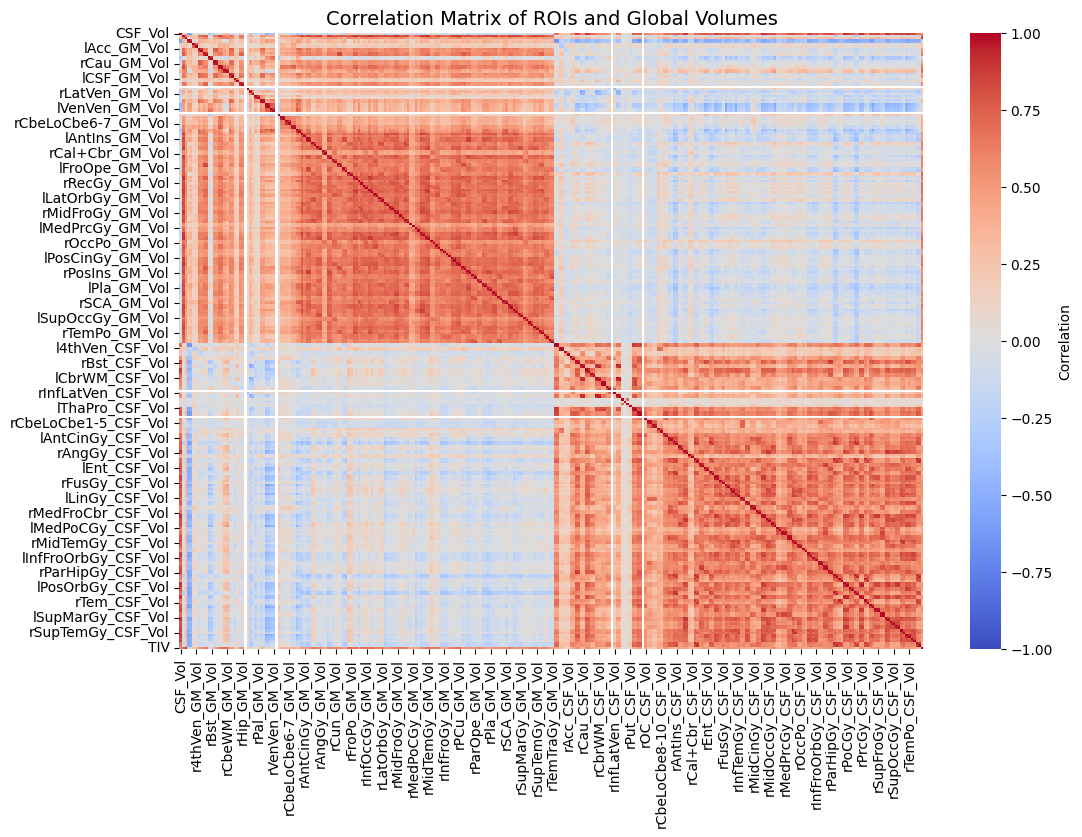

(GM_Vol                 1.000000
 lFusGy_GM_Vol          0.910715
 rMidTemGy_GM_Vol       0.910038
 rMidFroGy_GM_Vol       0.901943
 lMidTemGy_GM_Vol       0.899576
 lMidFroGy_GM_Vol       0.898366
 lInfTemGy_GM_Vol       0.897649
 lSupMedFroGy_GM_Vol    0.895013
 rPCu_GM_Vol            0.885353
 rFusGy_GM_Vol          0.885177
 Name: GM_Vol, dtype: float64,
 TIV                 1.000000
 WM_Vol              0.882284
 rInfTemGy_GM_Vol    0.741551
 lFroPo_GM_Vol       0.730347
 GM_Vol              0.723424
 rFroPo_GM_Vol       0.714775
 rPCu_GM_Vol         0.713203
 rInfOccGy_GM_Vol    0.712435
 rFusGy_GM_Vol       0.707923
 lCbeWM_GM_Vol       0.706980
 Name: TIV, dtype: float64)

In [42]:
# Selecting only the ROI columns for correlation analysis
roi_columns = [col for col in rois_with_diagnosis_fixed.columns if '_Vol' in col]
roi_data = rois_with_diagnosis_fixed[roi_columns]

# Adding global volumes for correlation analysis
roi_data_with_globals = roi_data.copy()
roi_data_with_globals['TIV'] = rois_with_diagnosis_fixed['TIV']
roi_data_with_globals['GM_Vol'] = rois_with_diagnosis_fixed['GM_Vol']
roi_data_with_globals['WM_Vol'] = rois_with_diagnosis_fixed['WM_Vol']

# Computing the correlation matrix
correlation_matrix = roi_data_with_globals.corr()

# Visualizing the correlation matrix (heatmap)
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, cmap='coolwarm', center=0, cbar_kws={'label': 'Correlation'}, vmax=1, vmin=-1)
plt.title('Correlation Matrix of ROIs and Global Volumes', fontsize=14)
plt.show()

# Identifying top correlated features with GM_Vol and TIV
top_correlated_with_gm = correlation_matrix['GM_Vol'].sort_values(ascending=False).head(10)
top_correlated_with_tiv = correlation_matrix['TIV'].sort_values(ascending=False).head(10)

top_correlated_with_gm, top_correlated_with_tiv


In [ ]:
"""
Visualisation de la matrice de corrélation :

La heatmap montre des corrélations fortes entre certains ROIs et les volumes globaux (TIV, GM_Vol, etc.).
Les ROIs dans des régions similaires (par exemple, gauche et droite) tendent à être fortement corrélés.
"""

In [ ]:
"""
Top corrélations avec GM_Vol (matière grise) :

ROIs les plus corrélés :
lFusGy_GM_Vol (gyrus fusiforme gauche, r=0.91).
rMidTemGy_GM_Vol (gyrus temporal moyen droit, r=0.91).
D'autres régions, principalement dans les gyri temporaux et frontaux.
"""

In [ ]:
"""
Top corrélations avec TIV (volume intracrânien total) :

ROIs les plus corrélés :
rInfTemGy_GM_Vol (gyrus temporal inférieur droit, r=0.74).
lFroPo_GM_Vol (gyrus frontal postérieur gauche, r=0.73).
Volumes globaux comme WM_Vol (r=0.88) et GM_Vol (r=0.72) sont aussi liés à TIV.
"""

C:\Users\chemm\AppData\Local\Temp\ipykernel_15240\947407753.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=rois_with_diagnosis_fixed, x='diagnosis', y=roi, palette='pastel')


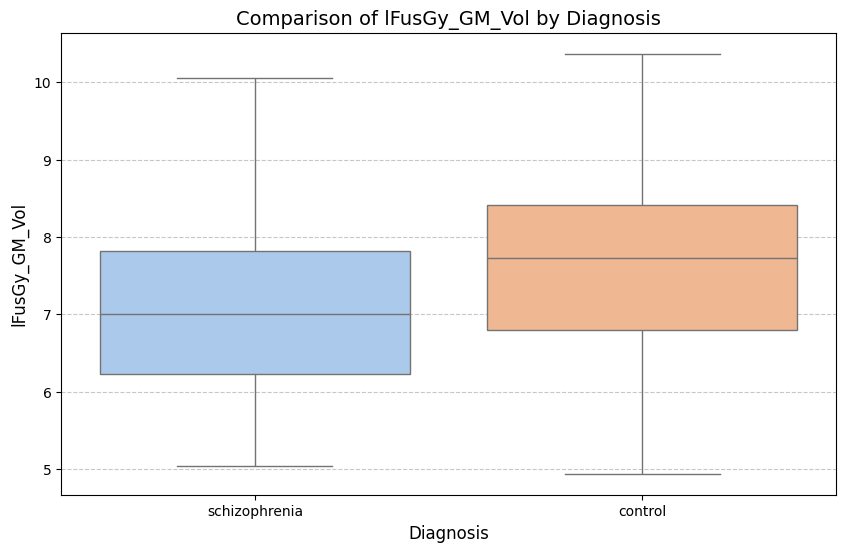

C:\Users\chemm\AppData\Local\Temp\ipykernel_15240\947407753.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=rois_with_diagnosis_fixed, x='diagnosis', y=roi, palette='pastel')


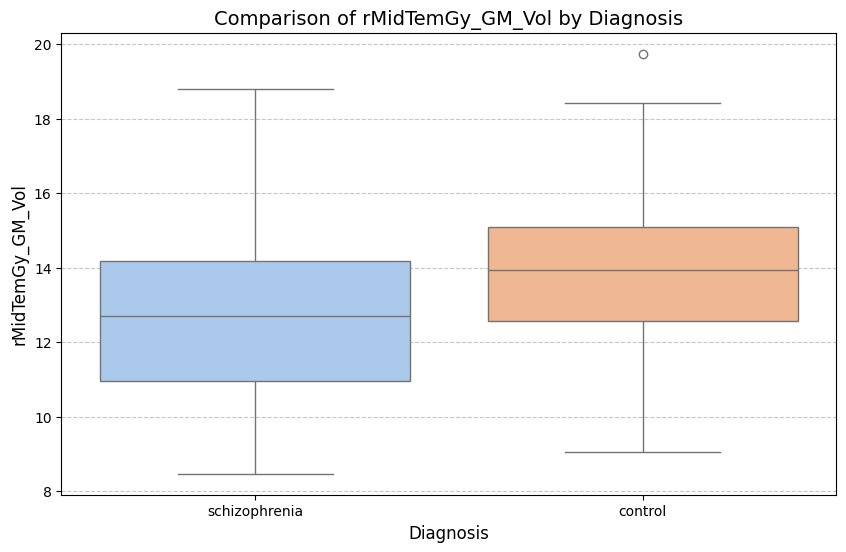

C:\Users\chemm\AppData\Local\Temp\ipykernel_15240\947407753.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=rois_with_diagnosis_fixed, x='diagnosis', y=roi, palette='pastel')


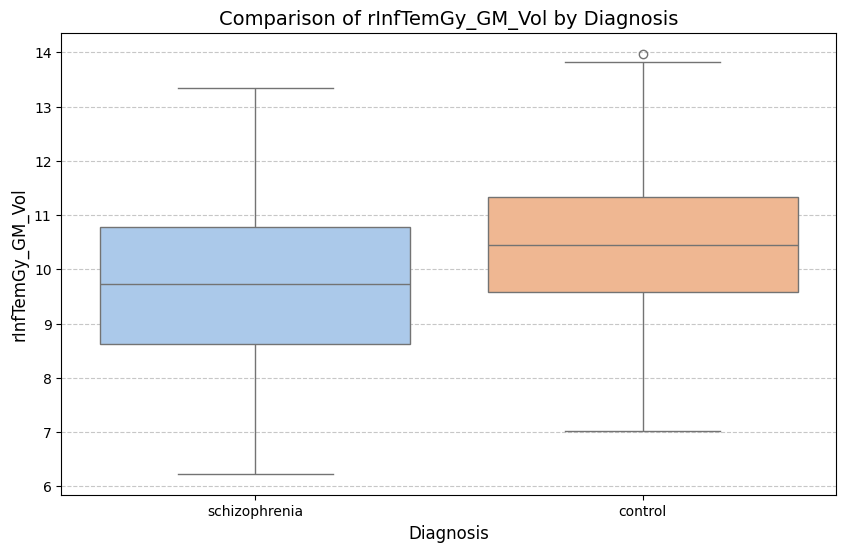

C:\Users\chemm\AppData\Local\Temp\ipykernel_15240\947407753.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=rois_with_diagnosis_fixed, x='diagnosis', y=roi, palette='pastel')


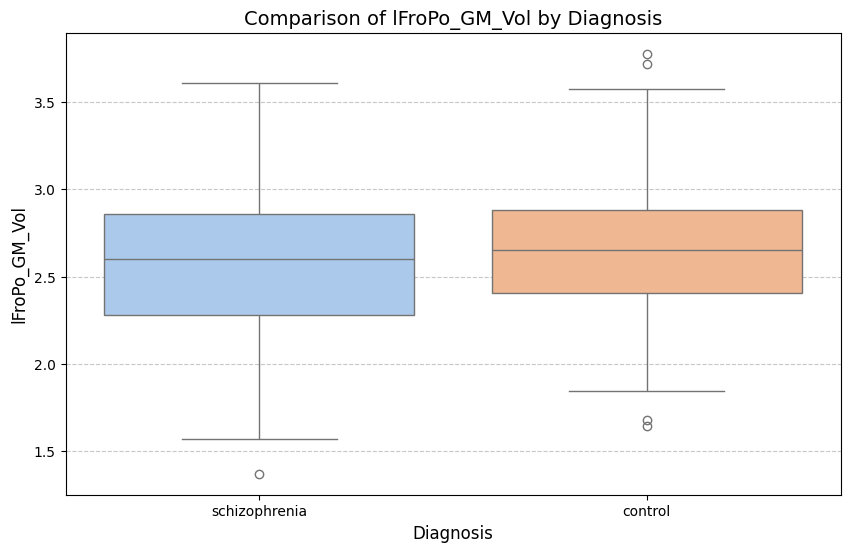

{'lFusGy_GM_Vol': TtestResult(statistic=np.float64(5.649324609868086), pvalue=np.float64(3.072590342320398e-08), df=np.float64(397.87111457644124)),
 'rMidTemGy_GM_Vol': TtestResult(statistic=np.float64(5.946174699613392), pvalue=np.float64(6.1564596152606865e-09), df=np.float64(385.4374320791293)),
 'rInfTemGy_GM_Vol': TtestResult(statistic=np.float64(5.362219885805771), pvalue=np.float64(1.4251467205245466e-07), df=np.float64(382.66822503251143)),
 'lFroPo_GM_Vol': TtestResult(statistic=np.float64(1.5216209590825982), pvalue=np.float64(0.12892081733115462), df=np.float64(386.949698446518))}

In [43]:
# ROIs to analyze
selected_rois = ['lFusGy_GM_Vol', 'rMidTemGy_GM_Vol', 'rInfTemGy_GM_Vol', 'lFroPo_GM_Vol']

# Boxplots for each selected ROI by diagnosis
for roi in selected_rois:
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=rois_with_diagnosis_fixed, x='diagnosis', y=roi, palette='pastel')
    plt.title(f'Comparison of {roi} by Diagnosis', fontsize=14)
    plt.xlabel('Diagnosis', fontsize=12)
    plt.ylabel(roi, fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

# Perform t-tests for the selected ROIs
ttest_results_rois = {
    roi: ttest_ind(
        rois_with_diagnosis_fixed[rois_with_diagnosis_fixed['diagnosis'] == 'control'][roi],
        rois_with_diagnosis_fixed[rois_with_diagnosis_fixed['diagnosis'] == 'schizophrenia'][roi],
        equal_var=False
    ) for roi in selected_rois
}

ttest_results_rois


In [ ]:
"""
Les ROIs fortement corrélés avec GM_Vol (comme lFusGy_GM_Vol et rMidTemGy_GM_Vol) jouent également un rôle important dans la différenciation des classes.
lFroPo_GM_Vol, bien que corrélé à TIV, ne semble pas significatif pour différencier les diagnostics.
"""

In [46]:
# Feature Engineering: Creating new variables
feature_engineered_df = rois_with_diagnosis_fixed.copy()

# 1. Ratios and proportions
feature_engineered_df['GM_WM_Ratio'] = feature_engineered_df['GM_Vol'] / feature_engineered_df['WM_Vol']
for roi in selected_rois:
    feature_engineered_df[f'{roi}_TIV_Ratio'] = feature_engineered_df[roi] / feature_engineered_df['TIV']

# 2. Differences between hemispheres (example for l/r ROIs in selected_rois)
feature_engineered_df['lFusGy_rFusGy_Diff'] = feature_engineered_df['lFusGy_GM_Vol'] - feature_engineered_df['rMidTemGy_GM_Vol']

# 3. Regional groupings (sum volumes of similar regions - example for temporals)
temporal_rois = [col for col in feature_engineered_df.columns if 'TemGy' in col]
feature_engineered_df['Temporal_ROI_Sum'] = feature_engineered_df[temporal_rois].sum(axis=1)

# 4. Normalization by TIV for all ROIs
for roi in roi_columns:
    feature_engineered_df[f'{roi}_Normalized'] = feature_engineered_df[roi] / feature_engineered_df['TIV']

# 5. Standardization (z-score)
from scipy.stats import zscore
roi_standardized_cols = [f'{roi}_Standardized' for roi in roi_columns]
feature_engineered_df[roi_standardized_cols] = feature_engineered_df[roi_columns].apply(zscore, axis=0)

# Preview the newly created features
new_features = [
    'GM_WM_Ratio', 
    'lFusGy_rFusGy_Diff', 
    'Temporal_ROI_Sum', 
    'lFusGy_GM_Vol_TIV_Ratio', 
    'lFusGy_GM_Vol_Normalized', 
    'lFusGy_GM_Vol_Standardized'
]
feature_engineered_df[new_features].head()


C:\Users\chemm\AppData\Local\Temp\ipykernel_15240\218352134.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  feature_engineered_df[f'{roi}_Normalized'] = feature_engineered_df[roi] / feature_engineered_df['TIV']
C:\Users\chemm\AppData\Local\Temp\ipykernel_15240\218352134.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  feature_engineered_df[f'{roi}_Normalized'] = feature_engineered_df[roi] / feature_engineered_df['TIV']
C:\Users\chemm\AppData\Local\Temp\ipykernel_15240\218352134.py:18: PerformanceWarning: DataFrame is hi

,GM_WM_Ratio,lFusGy_rFusGy_Diff,Temporal_ROI_Sum,lFusGy_GM_Vol_TIV_Ratio,lFusGy_GM_Vol_Normalized,lFusGy_GM_Vol_Standardized
0,1.274046,-8.246894,89.968490,0.004602,0.004602,0.450045
1,1.244513,-7.495846,88.669545,0.004943,0.004943,0.914125
2,1.166864,-6.827599,75.630425,0.005506,0.005506,0.538329
3,1.323948,-5.411982,63.014374,0.005428,0.005428,-0.829123
4,1.354405,-6.999432,82.044326,0.005442,0.005442,0.787846


In [48]:
# Define the regions with corresponding ROIs
regions = {
    "cortex_prefrontal": [
        'lMedOrbGy_GM_Vol', 'rMedOrbGy_GM_Vol', 'lMidFroGy_GM_Vol', 'rMidFroGy_GM_Vol',
        'lSupMedFroGy_GM_Vol', 'rSupMedFroGy_GM_Vol', 'lInfFroGy_GM_Vol', 'rInfFroGy_GM_Vol',
        'lFroPo_GM_Vol', 'rFroPo_GM_Vol', 'lAntCinGy_GM_Vol', 'rAntCinGy_GM_Vol',
        'lMidCinGy_GM_Vol', 'rMidCinGy_GM_Vol', 'lLatOrbGy_GM_Vol', 'rLatOrbGy_GM_Vol',
        'lAntOrbGy_GM_Vol', 'rAntOrbGy_GM_Vol', 'lMedPrcGy_GM_Vol', 'rMedPrcGy_GM_Vol',
        'lFroOpe_GM_Vol', 'rFroOpe_GM_Vol'
    ],
    "lobes_temporaux": [
        'lMidTemGy_GM_Vol', 'rMidTemGy_GM_Vol', 'lInfTemGy_GM_Vol', 'rInfTemGy_GM_Vol',
        'lSupTemGy_GM_Vol', 'rSupTemGy_GM_Vol', 'lParHipGy_GM_Vol', 'rParHipGy_GM_Vol',
        'lAmy_GM_Vol', 'rAmy_GM_Vol', 'lHip_GM_Vol', 'rHip_GM_Vol', 'lTemPo_GM_Vol',
        'rTemPo_GM_Vol', 'lTemTraGy_GM_Vol', 'rTemTraGy_GM_Vol'
    ],
    "thalamus": [
        'lThaPro_GM_Vol', 'rThaPro_GM_Vol', 'lCau_GM_Vol', 'rCau_GM_Vol', 'lPut_GM_Vol', 'rPut_GM_Vol'
    ],
    "ventricules": [
        'l3thVen_GM_Vol', 'r3thVen_GM_Vol', 'l4thVen_GM_Vol', 'r4thVen_GM_Vol',
        'lInfLatVen_GM_Vol', 'rInfLatVen_GM_Vol', 'lLatVen_GM_Vol', 'rLatVen_GM_Vol',
        'lVenVen_GM_Vol', 'rVenVen_GM_Vol', 'lAcc_CSF_Vol', 'rAcc_CSF_Vol', 'CSF_Vol'
    ],
    "cervelet": [
        'lCbeLoCbe1-5_GM_Vol', 'rCbeLoCbe1-5_GM_Vol', 'lCbeLoCbe6-7_GM_Vol', 'rCbeLoCbe6-7_GM_Vol',
        'lCbeLoCbe8-10_GM_Vol', 'rCbeLoCbe8-10_GM_Vol', 'lExtCbe_GM_Vol', 'rExtCbe_GM_Vol',
        'lCbeWM_GM_Vol', 'rCbeWM_GM_Vol'
    ],
    "matiere_blanche": [
        'WM_Vol', 'lCbrWM_GM_Vol', 'rCbrWM_GM_Vol', 'lCbr+Mot_GM_Vol', 'rCbr+Mot_GM_Vol'
    ],
    "cortex_parietal": [
        'lSupParLo_GM_Vol', 'rSupParLo_GM_Vol', 'lPCu_GM_Vol', 'rPCu_GM_Vol', 
        'lPoCGy_GM_Vol', 'rPoCGy_GM_Vol'
    ],
    "cortex_occipital": [
        'lInfOccGy_GM_Vol', 'rInfOccGy_GM_Vol', 'lMidOccGy_GM_Vol', 'rMidOccGy_GM_Vol',
        'lSupOccGy_GM_Vol', 'rSupOccGy_GM_Vol', 'lCal+Cbr_GM_Vol', 'rCal+Cbr_GM_Vol'
    ],
    "amygdale": [
        'lAmy_GM_Vol', 'rAmy_GM_Vol', 'lAmy_CSF_Vol', 'rAmy_CSF_Vol'
    ]
}

# Calculate aggregated volumes for each region
for region, rois in regions.items():
    feature_engineered_df[f'{region}_Sum'] = feature_engineered_df[rois].sum(axis=1)

# Display a preview of the aggregated regions
aggregated_columns = [f'{region}_Sum' for region in regions.keys()]
feature_engineered_df[aggregated_columns].head()


C:\Users\chemm\AppData\Local\Temp\ipykernel_15240\426552203.py:48: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  feature_engineered_df[f'{region}_Sum'] = feature_engineered_df[rois].sum(axis=1)
C:\Users\chemm\AppData\Local\Temp\ipykernel_15240\426552203.py:48: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  feature_engineered_df[f'{region}_Sum'] = feature_engineered_df[rois].sum(axis=1)
C:\Users\chemm\AppData\Local\Temp\ipykernel_15240\426552203.py:48: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result

,cortex_prefrontal_Sum,lobes_temporaux_Sum,thalamus_Sum,ventricules_Sum,cervelet_Sum,matiere_blanche_Sum,cortex_parietal_Sum,cortex_occipital_Sum,amygdale_Sum
0,121.560625,103.421482,29.995289,379.676942,101.357190,612.875118,73.091763,41.231345,2.235353
1,118.856728,104.361133,21.414210,401.832449,95.584662,602.177693,70.600637,40.796011,2.187364
2,109.974019,96.380386,28.818950,223.762905,92.693563,589.044952,59.835123,32.205955,2.139221
3,95.655843,78.774756,24.954892,204.241448,71.536409,443.267961,47.444514,30.358701,1.843902
4,114.751888,101.924320,28.031279,294.647032,93.610809,545.357422,65.103731,40.030744,2.129215


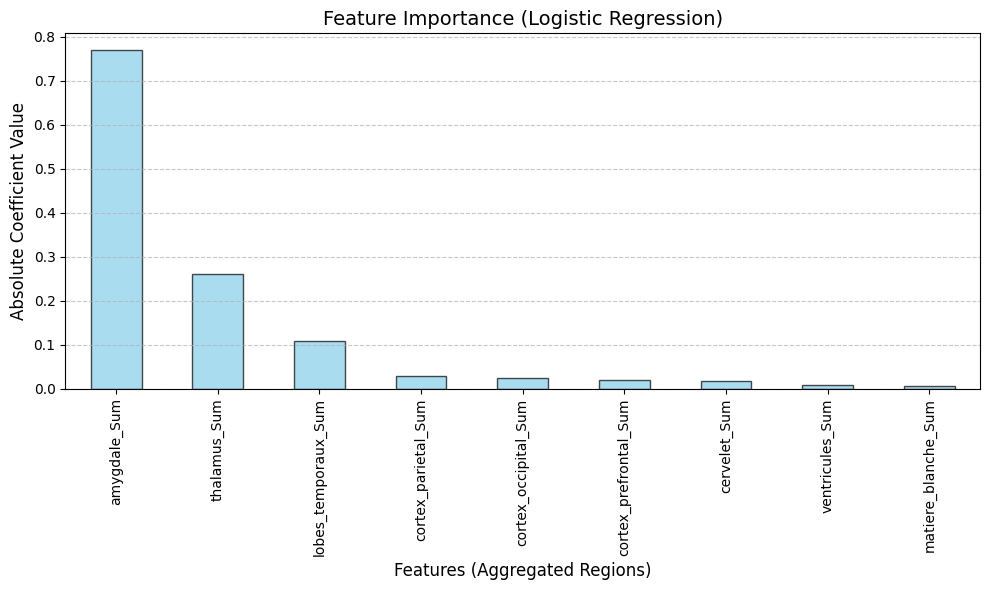

(np.float64(0.7918443496801706),
 '               precision    recall  f1-score   support\n\n      Control       0.67      0.84      0.75        67\nSchizophrenia       0.72      0.52      0.60        56\n\n     accuracy                           0.69       123\n    macro avg       0.70      0.68      0.68       123\n weighted avg       0.70      0.69      0.68       123\n',
 amygdale_Sum             0.769601
 thalamus_Sum             0.261069
 lobes_temporaux_Sum      0.107350
 cortex_parietal_Sum      0.028949
 cortex_occipital_Sum     0.024684
 cortex_prefrontal_Sum    0.018479
 cervelet_Sum             0.016342
 ventricules_Sum          0.007556
 matiere_blanche_Sum      0.005116
 dtype: float64)

In [49]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import roc_auc_score, classification_report
import matplotlib.pyplot as plt

# Prepare the data: include only the aggregated regional sums and the target
X_aggregated = feature_engineered_df[[f'{region}_Sum' for region in regions.keys()]]
y = feature_engineered_df['diagnosis_encoded']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_aggregated, y, test_size=0.3, random_state=42, stratify=y)

# Train a Logistic Regression model with cross-validation
logreg_cv = LogisticRegressionCV(cv=5, max_iter=1000, random_state=42, scoring='roc_auc')
logreg_cv.fit(X_train, y_train)

# Evaluate the model on the test set
y_pred_proba = logreg_cv.predict_proba(X_test)[:, 1]  # Probabilities for class 1 (schizophrenia)
roc_auc = roc_auc_score(y_test, y_pred_proba)
classification_report_str = classification_report(y_test, (y_pred_proba > 0.5).astype(int), target_names=['Control', 'Schizophrenia'])

# Feature importance (absolute coefficients)
feature_importance = pd.Series(abs(logreg_cv.coef_[0]), index=X_aggregated.columns).sort_values(ascending=False)

# Plot feature importance
plt.figure(figsize=(10, 6))
feature_importance.plot(kind='bar', color='skyblue', edgecolor='k', alpha=0.7)
plt.title('Feature Importance (Logistic Regression)', fontsize=14)
plt.ylabel('Absolute Coefficient Value', fontsize=12)
plt.xlabel('Features (Aggregated Regions)', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

roc_auc, classification_report_str, feature_importance
